# Analyzing NYC High School Data by Pavel Gladkevich

This project was completed as part of the Data Analyst series of Dataquest on 11/21/19

Goal: The city of New York makes its SAT data available online ([2011 NYC School Survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)) along with its demographics ([DOE Highschool Directory](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)). The efficacy of the SAT test is a [controversial topic](https://magoosh.com/hs/sat/2016/sat-test-controversies/) in the U.S. and there is a possibility that it is unfair to certain groups. Thus, it would be interesting to explore the correlations of the SAT scores with demographic information such as race, gender, or income.

Here are all of the datasets we will be using: 

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)- Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

# Read in the data
Before we perform analysis we need to convert the csv files into pandas dataframes that are accessible by their name as the key in a dictionary.

In [662]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# List of datasets
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Create a dictionary to store the datasets by key
data = {}

# Iterate through the list of datasets
for f in data_files:
    # Read each dataset into a dataframe
    d = pd.read_csv("/Users/pgladkevich/Desktop/coding/projects/datasets/Analyzing_NYC_High_School_Data/{0}".format(f))
    # Store it as a key-value pair
    data[f.replace(".csv", "")] = d

# Read in the Surveys
We can do the same for the csv's that contain survey data and then combine it into a single survey dataframe. Then, since we will be indexing by DBN, which stands for District Borough Number (a unique id for each school), and we will want to convert survey 'dbn' from lowercase to uppercase. Then based off of the data dictionary (image below), we will select only the columns necessarry for our analysis from the 2000 available.
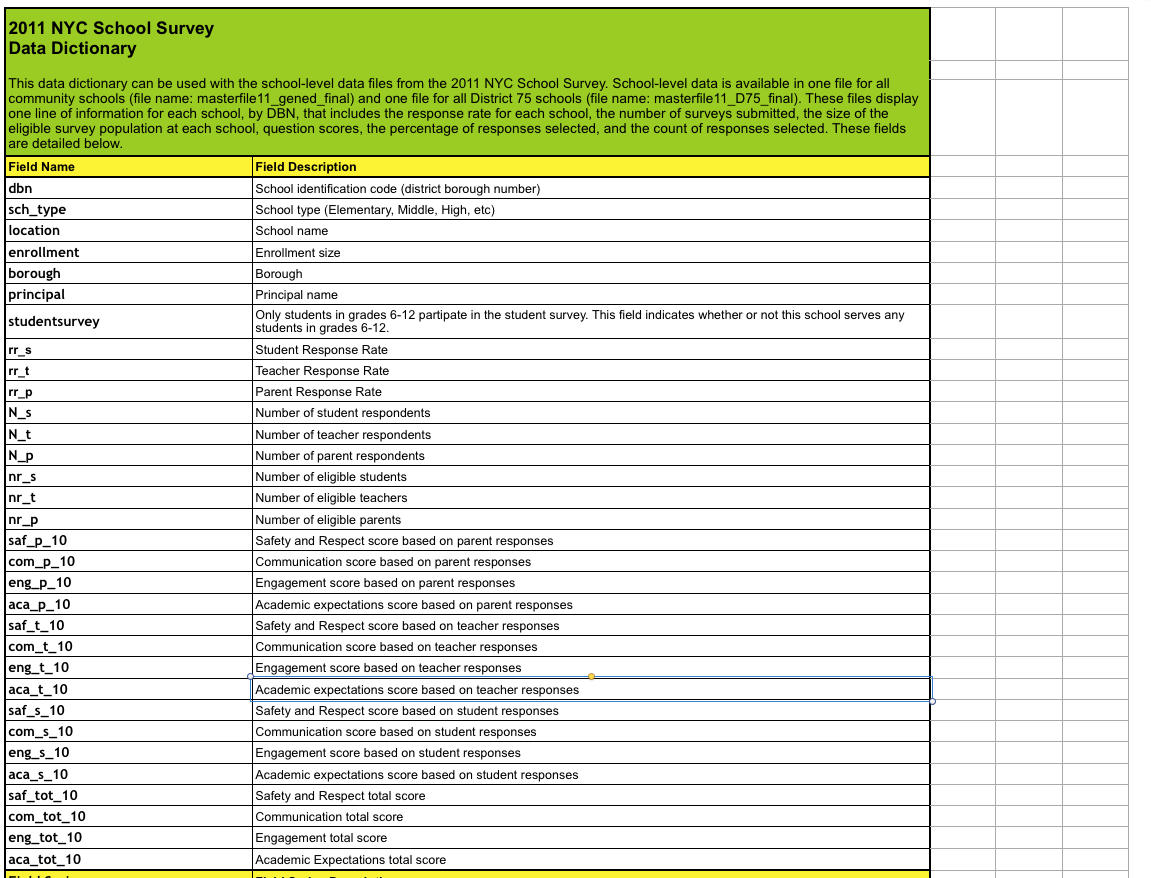


In [663]:
# The files are tab delimited and encoded with Windows-1252
all_survey = pd.read_csv("/Users/pgladkevich/Desktop/coding/projects/datasets/Analyzing_NYC_High_School_Data/survey_all.txt",
                         delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("/Users/pgladkevich/Desktop/coding/projects/datasets/Analyzing_NYC_High_School_Data/survey_d75.txt", 
                         delimiter="\t", encoding='windows-1252')

# Combine the two surveys across the rows, so that d75_survey is appended below all_survey
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

# Create a new column that is a duplicate of dbn for data consistency 
survey["DBN"] = survey["dbn"]

# Select the necessarry fields from the survey dataframe by first creating a list
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Iterate through the list and select leave only relevant columns in survey dataframe
survey = survey.loc[:,survey_fields]
# Create new database titled survey with the selcted columns
data["survey"] = survey

# Add DBN columns

Because the hs_directory dataset does not have DBN column and has a dbn column we will need to rename it. Additionally, the class_size dataset does not contain any column marked as DBN or dbn so we will need to create it. The DBN column is equivalent to the zero padded CSD (This is where a single digit number is first "led" by a zero")  + the School Code columns of the class_size dataset. Thus, we will create our needed DBN column by combining the two with a function.

In [664]:
# Rename a column of hs_directory for consistency
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Create a function that takes a number and adds a zero to the front if it is a single digit
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# Apply our function to create an intermediary padded CSD column in the class_size dataset    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
# Create the new DBN column by combining the padded CSD with the School Code
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

We will want to create a column that sums the Math, Reading, and Writing scores for a total SAT score, but before we can use the sum function we must convert the values in the columns from strings to a numerical format. We will then combine the numeric values to a new column in the sat_results dataset. Additionally, the latitude and longitude data of each school is important for our geographical analysis of the data, so we will create two functions using regular expressions to extract only the coordinate information from the Location columns of hs_directory.

In [665]:
# Form a list of the three columns we will be converting
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
# Use a loop to cycle through the list and transform the column data to numerical 
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
# Combine the results of Math, Reading, and Writing columns together into a Total Score
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Function for extracting the latitude from column input
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Function for extracting the longitude from column input
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Apply the above function to create new columns corresponding to latitude and longitude
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Convert the two newly created columns to numerical data
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

Before we combine the datasets using our newly created DBN columns we must first ensure that there won't be collisions. There are several cases where multiple rows of class_size match a singular row of sat_results, so we will condense the class_size, graduation, and demographics data sets in such a way that renders each DBN to a unique entry in each dataset. We will also alter the demographics dataset to only include the most recent year of data. Lastly the graduation dataset does not have each DBN correspond to a unique row because of the Cohort and Demographic columns, so we will condense this dataset by selecting only the most recent year's data available, which is 2006.

In [666]:
# Create a variable to store only the results of highschool students in a general education program
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Aggregate the classes based off of the DBN and take the average of each group 
class_size = class_size.groupby("DBN").agg(np.mean)
# Change the index so that DBN is a column again
class_size.reset_index(inplace=True)
# Update the class_size database with our standardized version
data["class_size"] = class_size
# Select only the most recent year of demographics data, which has been stored as an int
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Filter the graduation dataset by selecting only 2006 and Total Cohort for Cohort and Demographic
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

Now we have to convert that [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) Test Scores from string values to numeric. We will use these values to compare correlations of AP to SAT scores. Passing scores on the AP exams are 3, 4, and 5 on a 1 to 5 scale.

In [667]:
# Create a dictionary that we will use to filter the ap_2010 dataset
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# Loop through cols and use errors="coerce" to set invalid parsing as NaN
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

We will combine the datasets into one dataframe by using a series of merges. For the sat_results and ap_2010 datasets we will use a left merge so that DBN values from sat_results will be preserved as the SAT data is the most important, and DBN's without corresponding data in ap_2010 will be filled with NaN. We will repeat this process for the graduation dataset. For the remaining datasets of class_size, demographics, survey, and hs_directory we will use an inner merge. These datasets have vital information for analysis and it would be best to get rid of any rows in the sat_results dataset that have corresponding data in the other four datasets. Any remaining missing values in the dataset we will fill with the mean of the columns.

In [668]:
# Create a dataframe that will house all results
combined = data["sat_results"]

# Use left merges on the two datsets that we can accept NaN values in
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# List of remaining datasets
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

# Loop through the list and inner merge the remaining datsets sequentially
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Fill the missing values with the column averages
combined = combined.fillna(combined.mean())
# If a column is entirely full of NaN values the mean function won't return a value so fill with 0
combined = combined.fillna(0)

combined.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


# Add a school district column for mapping

We will want to add a column for school district so that we can map the statistical data on a geographical map of New York.

In [669]:
# Create a function to extract only the school district characters of the DBN code
def get_first_two_chars(dbn):
    return dbn[0:2]

# Apply our function to create a new column
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

We will use the Pearson's correlation coefficient (r value) to measure how closely the values of our datasets are correlated to the SAT scores. 

In [670]:
# Library for creating excel files
import xlsxwriter

# Create a correlation object of all columns
correlations = combined.corr()
# Select only correlations of all columns to sat_score
correlations = correlations["sat_score"]
print(correlations)

_="""
This is code that I used to explore the results in an excel file so that output wasn't truncated.

writer = pd.ExcelWriter('/Users/pgladkevich/Desktop/coding/projects/datasets/NYC_correlations.xlsx', engine='xlsxwriter')
correlations.to_excel(writer, sheet_name='Sheet1')
writer.save()
"""

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

It is a given that the sat_score column will correlate perfectly positively to it's own values, and it is also unsurprising that SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score correlate strongly positive as well. Surprisingly there is a slightly weaker but still a moderate positive correlation of SAT scores with AVERAGE CLASS SIZE, total_enrollment, and Total Cohort (Moderately positive being +.3 to .7). Intuitively we would expect smaller class-sizes to improve a student's test-taking ability as they would theoretically receive more personalized attention, but that appears to not be the case here. This is also true for other columns that relate to enrollment data such as N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS. The percentage race columns such as asian_per and white_per columns correlate moderately positively, while the hispanic_per and black_per columns correlate approximately moderate negative. From this we can infer that there is likely some racial inequality. Lastly, the percentage of females (female_per) correlates weakly positive with SAT score, whereas the percentage of males (male_per) correlate weakly negative. This could indicate that women do better on the SAT than men. We will continue to explore the correlations via a barplot graph.

In [671]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
# Create a series that is only the correlations relevant to our planned analysis 
corr = correlations[survey_fields]
corr

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

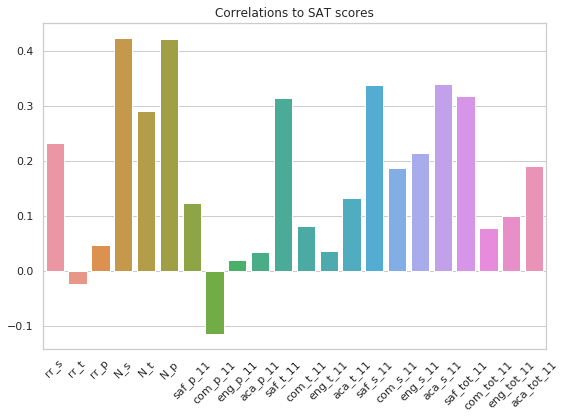

In [672]:
# Created the matplotlib.pyplot figure and axes objects
f,ax = plt.subplots(figsize=(9,6))
# Use the seaborn library to create a barplot of the correlations 
sns.barplot(x=corr.index, y=corr.values, ax=ax)
# Set title
plt.title("Correlations to SAT scores")
# Rotate x-axis labels for readability
_= ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Interestingly there are morderately positive correlations between N_s, N_t, N_p (Number of student, teacher, and parent responses) which means that schools that had lots of respondents correlated with better SAT scores. This is again indicative of an enrollment association. Additionally, there is a moderately positive correlation with saf_t_11 and saf_s_11 (Safety and respect scores based on teacher and student repsonses), but the saf_p_11 (parent safety and respect score) is only weakly positively correlated. This makes sense as students that do not feel safe at school would likely underperform on examinations. Only the aca_s_11 (Academic expectations score based on student responses) is moderately correlated, which might mean that parents and teachers (aca_p_11, aca_t_11) are far less attuned to student's potential results than the students themselves. 

# Exploring Safety and Respect Scores

Since we have noticed that the student and teacher safety scores correlated moderately positive to the SAT results, we will want to explore this correlation more thoroughly. We will use a scatterplot to do so. 

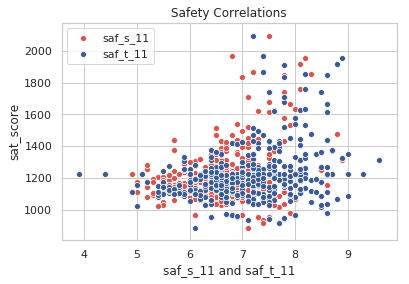

In [673]:
# Create two scatterplots overlayed on top of eachother that are the student and teacher safety scores
ax = sns.scatterplot(x="saf_s_11", y = "sat_score", color= sns.xkcd_rgb["pale red"], data=combined)
ax = sns.scatterplot(x="saf_t_11", y = "sat_score", color= sns.xkcd_rgb["denim blue"], data=combined)

# Set the xlabel so that it isn't incorrectly marked as only saf_t_11
_= ax.set_xlabel("saf_s_11 and saf_t_11")
_= ax.legend(['saf_s_11','saf_t_11'])
_= plt.title("Safety Correlations")

From the graphs it looks like there is slight to moderate correlation between SAT scores and student and teacher safety ratings. In both survey results from students and teachers there is no school that has a safety rating of below six with a score on the SAT above 1500. This likely means that there is a threshold of safety below which it is not likely for students to be capable of performing well on the SAT. If we knew more advanced techniques we could perform logistical regression to determine this threhsold as there is no directly linear relationship visible that would apply to the entirety of the graph. There are also a few schools that have very high SAT scores and safety ratings. We can try computing the safety scores by district and plot them over a map to see if we can infer which neighborhoods are more dangerous. We can then check with google whether or not our predictions are accurate historically. 

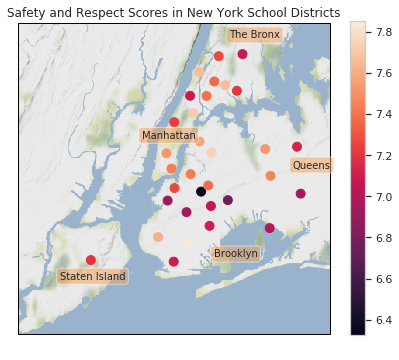

In [674]:
# Import the necessarry packages
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import statistics as stats

# Create a groupby object that calculates the means of all columns grouped by the 32 school districts
school_district_means = combined.groupby(["school_dist"]).agg(np.mean).reset_index()

# Create two lists storing the latitude and longitude coordinates of the 32 school districts
slat=school_district_means.loc[:,"lat"]
slon=school_district_means.loc[:,"lon"]
# Create a series object storing the school district mean safety scores
smeans=school_district_means.loc[:,"saf_tot_11"]

# Create a Stamen terrain background instance
stamen_terrain = cimgt.Stamen('terrain-background')

# Create the matplotlib figure object
fig = plt.figure(figsize=(7,7))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Limit the extent of the map to a small longitude/latitude range
ax.set_extent([-74.255735, -73.700272, 40.496044, 40.915256], crs=ccrs.Geodetic())

# Add the Stamen data at zoom level 10 to have significant resolution
ax.add_image(stamen_terrain, 10)

# Create a dictionary which we will iterate though to plot Borough labels
Boroughs = {"Brooklyn" : [-73.99,40.595], 
            "Queens": [-73.86,40.715],
            "Manhattan" : [-74.1,40.755],
            "Staten Island" : [-74.225,40.565],
            "The Bronx" : [-73.95,40.89]
           }
# Iterate through the key value pairs and create labels for the Boroughs via ax.text objects
for key in Boroughs.keys():   
    ax.text(Boroughs[key][0],Boroughs[key][1],key,verticalalignment='center', horizontalalignment='right',
        transform=text_transform,
        bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))

# Plot the scatterplot of Safety Scores along with a bar showing the levels
plt.scatter(slon, slat, s=80, c=smeans,transform=ccrs.Geodetic())
plt.colorbar(shrink=.825)
plt.title("Safety and Respect Scores in New York School Districts")
plt.show()

From our graph we can tell that the Brooklyn borough has some very poor safety scores across it's districts, although it also has the highest Safety Score in one school district. Queens, and The Bronx are about the same and Manhattan is just slightly better than them. Staten Island only has one school district that is also alright. Overall the Borough with the highest safety scores seems to be either Manhattan or the Bronx. 

# Exploring Racial Correlations

Previously we saw in the correlation object some of the columns relating to race were moderately significantly correlated either negatively or positively. Lets group these relationships and explore them further with a barplot.

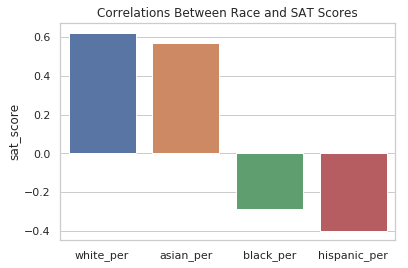

In [675]:
# Create a list of the columns relating to racial percentages of total enrollment in a a school
race_S = ["white_per", "asian_per", "black_per", "hispanic_per"]
# Select only racial correlations
corr_r = correlations[race_S]

# Create a seaborn barplot with a more viewer friendly style
sns.set(style="whitegrid")
sns.barplot(x=race_S,y=corr_r)
_= plt.title("Correlations Between Race and SAT Scores")

We can tell from our barplot that the amount of white and asian students in a highschool correlates highly moderate positive with higher sat_scores, while the black and hispanic students correlate weakly negative. To observe whether or not the trend is real, we will graph the hispanic percentage as a scatterplot.

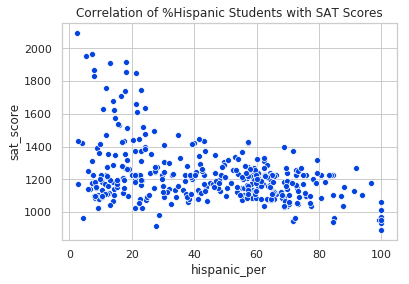

In [676]:
# Create a seaborn scatterplot of the correlations
_= sns.scatterplot(x="hispanic_per", y = "sat_score", color= sns.xkcd_rgb["blue"], data=combined)
_= plt.title("Correlation of %Hispanic Students with SAT Scores")

From the above graph we can tell that there is definitely a downward trend that is not a spurious correlation. There appears to be a relationship between the percentage of students in a school that are hispanic and the performance of students at this school on the SAT. In particular, the schools that have close to 100% hispanic students have all done received average SAT scores below 1400. We can explore some of the schools that have the highest percentage of hispanic students.

In [677]:
print(combined[combined["hispanic_per"] >= 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above schools describe themselves as catering to immigrants recently arrived from Spanish-speaking countries. Logically, on a test written entirely in English the students would be less likely to succeed. We can look at the other side of the spectrum to see what the schools with the lowest hispanic percentages describe themselves as.

In [678]:
print(combined[(combined["hispanic_per"] <=10) &(combined["sat_score"]> 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools above appear to largely be technical schools that receive extra funding and only admit students who pass an entrance exam. Thus, they are students from all over New York City who did well on a standardized test and so they would logically do better on a SAT exam. This does not explain the lower percentage of hispanic students so further surveys would be necessarry to understand why hispanic students are not successsfully entering these programs.

# Exploring Gender and AP Exam Correlations

We previously saw that there was a very weak correlatory link between Gender and SAT scores, as well as a much stronger one between AP Exams and SAT scores. We can explore these two relationships and see how the R-value corresponds to shape of the scatterplot. We will first explore Gender with a barplot and then a scatterplot. Finally, we will compare this to the scatterplot of AP scores correlated to SAT scores.

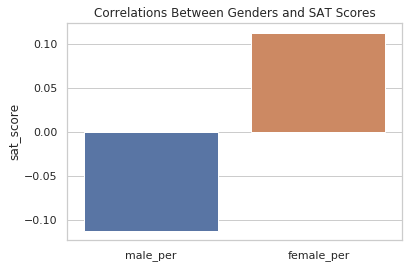

In [679]:
# The columns related to the genders
genders = ["male_per", "female_per"]

# Create the correlation objects for genders
corr_g = correlations[genders]

# Create the gender correlation barplot
sns.set(style="whitegrid")
sns.barplot(x=genders,y=corr_g)
_= plt.title("Correlations Between Genders and SAT Scores")

From the correlation barplot we can see that the correlation difference between the genders is mirrored as it should be, and that there is unlikely to be a strong observable relationship on a scatterplot.

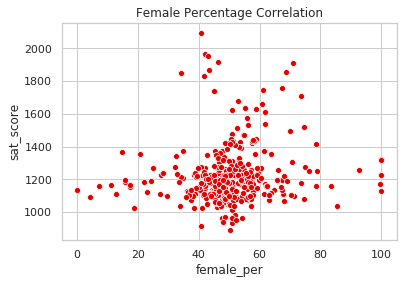

In [680]:
_= sns.scatterplot(x="female_per", y = "sat_score", color= sns.xkcd_rgb["red"], data=combined)
_= plt.title("Female Percentage Correlation")

As expected there is no correlation as the graph is spread out in all of the directions fairly equally. From this we can tell that there is unlikely to be a linear relationship between gender and SAT scores. There is a small cluster of schools in the upper right portion of the graph that have a high SAT score and a high female percentage. We will isolate these school names and perform a quick search on them.

In [681]:
print(combined[(combined["female_per"]>= 60) & (combined["sat_score"]>=1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above schools are all advanced liberal arts programs that are highly selective in enrollment of students. We will now explore AP score correlations. 

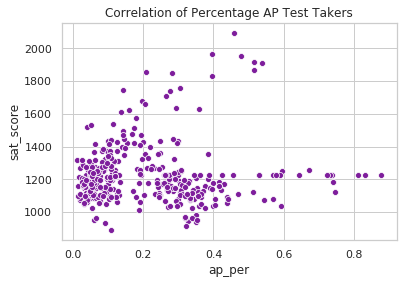

In [682]:
# We have to create the AP percentage column by taking total AP takers and dividing by total enrollment
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
_= sns.scatterplot(x="ap_per", y="sat_score", color=sns.xkcd_rgb["purple"], data=combined)
_= plt.title("Correlation of Percentage AP Test Takers")

Although the AP Test Takers column had a relatively high moderate correlation to SAT scores (0.523140), the scatterplot shows a weak correlation at best. So AP test takers might have a slight advantage but it is not a very indicative measurement of performance. 

# My Own Exploration

To see if there were any remaining relationships that were not explored by the creater of the Dataquest project I decided to sort the correlations by ascending.

In [683]:
correlations.sort_values(ascending=True).head(15)

frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
ell_num        -0.153778
lon            -0.132222
lat            -0.121029
com_p_11       -0.115073
male_per       -0.112062
zip            -0.063977
rr_t           -0.023386
eng_p_11        0.020254
hispanic_num    0.025744
black_num       0.027979
Name: sat_score, dtype: float64

We have found two additional columns of interest, 'frl_percent' which stands for 'free and reduced lunch', and 'sped_percent' which stands for 'special education learners.' It is logical that the special education learners would perform worse on exams that are designed for studnets that do not have any mental handicapps. As for frl_percent it is likely that the students that have either a free or a reduced price for their lunch come from a poorer background and do not have as much time or resources to spend on the SAT exam. We can observe these scatterplots to look at some nice linear relationships. 

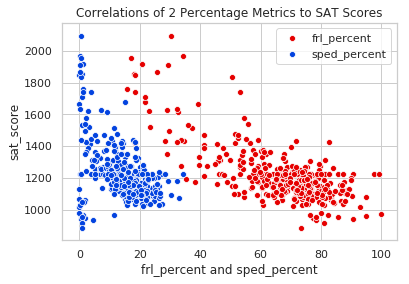

In [684]:
# Create the combined scatterplot so we can view the correlations to SAT scores
ax= sns.scatterplot(x="frl_percent", y="sat_score", color=sns.xkcd_rgb["red"], data=combined)
ax= sns.scatterplot(x="sped_percent", y="sat_score", color=sns.xkcd_rgb["blue"], data=combined)
_= plt.title("Correlations of 2 Percentage Metrics to SAT Scores")
_= ax.set_xlabel("frl_percent and sped_percent")
_= ax.legend(['frl_percent','sped_percent'])

The "special education" percentage corresponds to a very sharp decline in SAT scores for any percentage above roughly 5%. The correlation coefficient for it was not as strong as for the "free and reduced lunch" percentage which is visible as the scatterplot begins to cluster more densely and non-linearly at 20% and above. The "special education" percentage scatterplot also does not span as much of the x-axis, which must mean that schools in New York don't have special education only programs, or programs with more than 40% of special education students. There is also a cluster of dots that are very low in both SAT scores and sped_percent. This might be because those programs don't have many funds and so special education students are not present at those programs. The "free and reduced lunch" percentage has a fairly clear linear trend downard that spans from roughly 20% to 100%. It is a good example of a linear relationship in correlation, which makes sense given its very strong negative correlation to SAT score. With the exception of two outliers no program with more than 60% "free and reduced lunch" students has an average SAT score above 1400. 

# Conclusions

With this project we explored the datasets of NYC Highschools for some preliminary analysis to determine what factors correlate to performance on the SAT test. After cleaning the datasets we combined them into one dataframe in "tidy data" format. The strongest correlations we found were the strong negative correlation of "free and reduced lunch percentage", as well as the moderate negative correlation of"special education percentage." This makes sense as the former corresponds to student financial background and the latter to student disability status, both of which would impact detrimentally on a student's ability to perform well on the SAT exam. Additionally, the strongest positive correlation that we found were percentage of white students as well as asian students. The hispanic and black percentages were weakly negative correlated. Another moderate positive correlation was with student and teacher safety scores, which we plotted among the districts on a geographical map of New York and found that the Brooklyn borough was the worst while the Manhattan and Bronx boroughs were about tied for the best. Further research would be necessarry to determine why black and hispanic students are underperforming on SAT scores, as well as what could be done to help lower income students with the SAT. 

In [685]:
# Playing around with some graphing options

# xd = combined.loc[:,['white_per', 'saf_s_11','saf_t_11', 'sat_score']]
# xd[['white_per','saf_t_11', 'sat_score']].set_index('sat_score').plot(linewidth=0,marker='o', alpha=.5)
# ax = xd[['saf_s_11', 'sat_score']].set_index('sat_score').plot(linewidth=0,marker='o')
# ax = xd[['saf_t_11', 'sat_score']].set_index('sat_score').plot(linewidth=0,marker='o', alpha=.5, ax=ax)
# _= ax.legend(['saf_s_11','saf_t_11'])